# Introduction

The goal of this notebook is to provide an example of how to fine-tune a pre-trained encoder-decoder model for a specific task. Specifically, we build a pre-trained encoder-decoder from the pre-trained vision encoder [Swin Transformer](https://huggingface.co/microsoft/swin-base-patch4-window7-224-in22k) and the pre-trained decoder [GPT-2](https://huggingface.co/openai-community/gpt2) in order to generate the LaTeX code corresponding to the image of a mathematical formula. To do this, we make use of the Transformers, Datasets, and Trainer environment provided by Hugging Face, which offers a high-level overview of the fine-tuning process while providing great flexibility for fine-tuning.

# Set up the environment


We ran our experiments under the following environment:  

- **Python** 3.12.7  
- **matplotlib** 3.9.2  
- **torch** 2.5.1  
- **numpy** 1.26.4  
- **Pillow** 10.4.0  
- **transformers** 4.48.0  
- **datasets** 3.2.0  
- **evaluate** 0.4.3  

In [23]:
# Import the necessary libraries
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import (AutoProcessor, 
                          VisionEncoderDecoderModel, 
                          AutoTokenizer, 
                          GenerationConfig  ,
                          Seq2SeqTrainingArguments,
                          Seq2SeqTrainer,
                          EarlyStoppingCallback,)
from datasets import load_dataset, DownloadMode
import datasets
import torch
import numpy as np
import evaluate
from PIL import Image
import time
import os

In [24]:
# Allow parallel tokenization
os.environ["TOKENIZERS_PARALLELISM"] = "true"

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
# Set a seed for reproducibility
SEED = 78
set_seed(SEED)

# Set up the model

The model architecture and parameters are taken from the paper [Image-to-LaTeX Converter for Mathematical Formulas and Text](https://arxiv.org/abs/2408.04015).

In [25]:
encoder_name = "microsoft/swin-base-patch4-window7-224-in22k"
decoder_name = "gpt2"

# The VisionEncoderDecoderModel library constructs the model for us using a decoder and an encoder
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encoder_name, decoder_name).to(device)
processor = AutoProcessor.from_pretrained(encoder_name,use_fast=True) 
tokenizer = AutoTokenizer.from_pretrained(decoder_name,use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id

# Set generation configuration
generation_config = GenerationConfig(
    max_length=256,
    early_stopping=True,
    num_beams=4,
    length_penalty=2.0,
    no_repeat_ngram_size=3,
    decoder_start_token_id = tokenizer.bos_token_id
)
model.generation_config = generation_config
model.decoder.resize_token_embeddings(len(tokenizer))

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

Embedding(50257, 768)

# Load and preprocess the dataset

In [22]:
# We load two datasets avaible in the Hugging Face library
dataset_lynx = load_dataset("linxy/LaTeX_OCR",download_mode=DownloadMode.REUSE_CACHE_IF_EXISTS)
dataset_100k = load_dataset("yuntian-deng/im2latex-100k-raw",download_mode=DownloadMode.REUSE_CACHE_IF_EXISTS)

# K limits the number of examples to used to speed up the training
K = 10
if (K!=0):
    dataset_lynx["train"] = dataset_lynx["train"].select(range(K))
    dataset_100k["train"] = dataset_100k["train"].select(range(K))
    dataset_100k["test"] = dataset_100k["test"].select(range(K))
    dataset_100k["val"] = dataset_100k["val"].select(range(K))

# We concatenate the datasets
dataset_merged = datasets.concatenate_datasets([dataset_lynx["train"] , dataset_100k["train"] , dataset_100k["test"],dataset_100k["val"]  ])

# We define a function to preprocess the data and format it in the way the training loop expects
def format_data(observation):
    if (observation["preprocessing"] == None):
        observation["pixel_values"] = processor( observation["image"], return_tensors="pt").pixel_values
        observation["labels"] = tokenizer.encode(observation["text"],padding="max_length",max_length=model.generation_config.max_length,truncation=True)
    else:
        observation["pixel_values"] = processor( observation["image"], return_tensors="pt").pixel_values
        observation["labels"] = tokenizer.encode(observation["formula"],padding="max_length",max_length=model.generation_config.max_length,truncation=True)
    return observation

# We preprocess the data and split it in train, test and validation sets
dataset_merged = dataset_merged.map(format_data)
dataset_merged = dataset_merged.shuffle(seed=SEED)
dataset_merged = dataset_merged.train_test_split(test_size=0.1)
dataset_val_test = dataset_merged["test"].train_test_split(test_size=0.5)
dataset_train = dataset_merged["train"]
dataset_test = dataset_val_test["train"]
dataset_val = dataset_val_test["test"]

Generating train split:   0%|          | 0/76318 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/165099 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20430 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/18216 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

# Set up the training environment

In [11]:
# we define a datacollator to format the data in the way the training loop expects it
def custom_collate_fn(batch):
    """
    We store the batch in a tensor of shape (batch_size,3,224,224)
    - 3 is the number of channels: red, green and blue
    - 224 is the width and height of the image
    """
    pixel_values = torch.stack([torch.as_tensor(example["pixel_values"],device=device).squeeze(0) for example in batch])
    padded_labels = torch.as_tensor( [ example["labels"] for example in batch ] ,device=device)
    return {"pixel_values": pixel_values, "labels": padded_labels}

# We define a fonction to compute a metric in order to evaluate the model
bleu_metric = evaluate.load("bleu")
def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    # Decode the predictions and labels: we convert tokens into human readable text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Compute the BLEU score
    results = bleu_metric.compute(predictions=decoded_preds, references=[[lbl] for lbl in decoded_labels])
    return {"bleu": results["bleu"]}

In [ ]:
training_args = Seq2SeqTrainingArguments(
    # Output
    output_dir="trained vision encoder decoder",

    # Generation
    generation_num_beams=model.generation_config.num_beams,
    generation_max_length=model.generation_config.max_length,
    predict_with_generate=True,

    # parallelisation
    per_device_train_batch_size=16,
    learning_rate=5e-5,
    fp16=True if device.type == "cuda" else False,

    # Optimisation parameters
    num_train_epochs=5,
    dataloader_pin_memory=False,
    warmup_steps=500,
    weight_decay=0.01,

    # Saving, logging and evaluation
    save_strategy="epoch",
    save_total_limit=3,
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=1000,

    # Early stopping
    load_best_model_at_end=True, 
    metric_for_best_model="bleu",
    greater_is_better=True,

    # Reproductibility
    seed=SEED,
) 

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    data_collator=custom_collate_fn,
    callbacks=[EarlyStoppingCallback()],
    compute_metrics=compute_metrics,
    processing_class=processor
)

# Train and evaluate the model

In [ ]:
trainer.train()
trainer.eval_dataset = dataset_test
print(trainer.evaluate())

In [29]:
def show_data(sample):
    """
    Display the image and the expected text of any sample of the train, test or validation dataset
    """
    generated_text = tokenizer.decode(sample["labels"],skip_special_tokens=True)
    plt.imshow(sample["image"])
    plt.show()
    print(generated_text)

def inference_path(image_path):
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.show()
    pixel_values = processor(image,return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = tokenizer.decode(generated_ids[0],skip_special_tokens=True)
    print(generated_text)

def inference_dataset(sample):
    image = sample["image"]
    pixel_values = processor(image,return_tensors="pt").pixel_values.to(device)
    with torch.inference_mode():
        generated_ids = model.generate(pixel_values)
    generated_text = tokenizer.decode(generated_ids[0],skip_special_tokens=True)
    print(generated_text)

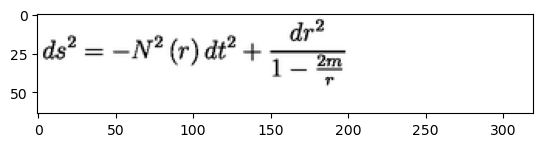

d s ^ { 2 } = - N ^ { 2 } \left( r \right) d t ^ { 2 } + \frac { d r ^ { 2 } } { 1 - \frac { 2 m } { r } }


In [ ]:
# Perform inference
show_data(dataset_test[0])
inference_dataset(dataset_test[0])

# Results and conclusion  

We trained the model on the entire dataset for 3 epochs and obtained a BLEU score of 0.23 on the test set. We ran the experiment on the high-performance computing platform Grid5000 using four Tesla V100 GPUs to speed up computation and ensure reproducibility.

More concretely, after testing the model on several samples from the test dataset, we observed that it generates LaTeX code that is extremely close to the correct version, although it occasionally makes small mistakes. The main issue is that towards the end of the generation, the model tends to diverge and produce unrelated code. However, this could be partially corrected with some post-processing.  

To further improve the results, future work could include using more data, possibly through data augmentation, and experimenting with different optimizers, such as the promising LoRA optimizer. Additionally, a model with higher parameter precision could enhance performance. We could also fine-tune the generation parameters to mitigate divergence issues—perhaps increasing the length penalty could help.

# References

- Image-to-LaTeX Converter for Mathematical Formulas and Text: https://arxiv.org/abs/2408.04015
- Hugginface Vision Encoder deocder models: https://huggingface.co/docs/transformers/en/model_doc/vision-encoder-decoder
- Hugginface Trainer: https://huggingface.co/docs/transformers/en/main_classes/trainer
- Hugginface Transformers: https://huggingface.co/docs/transformers/en/index